<a href="https://colab.research.google.com/github/Praveengovianalytics/GenAI-Data-2-Insights-bot/blob/main/Alex_DPM_Insight_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meet Alex DPM - Data Insights Generator

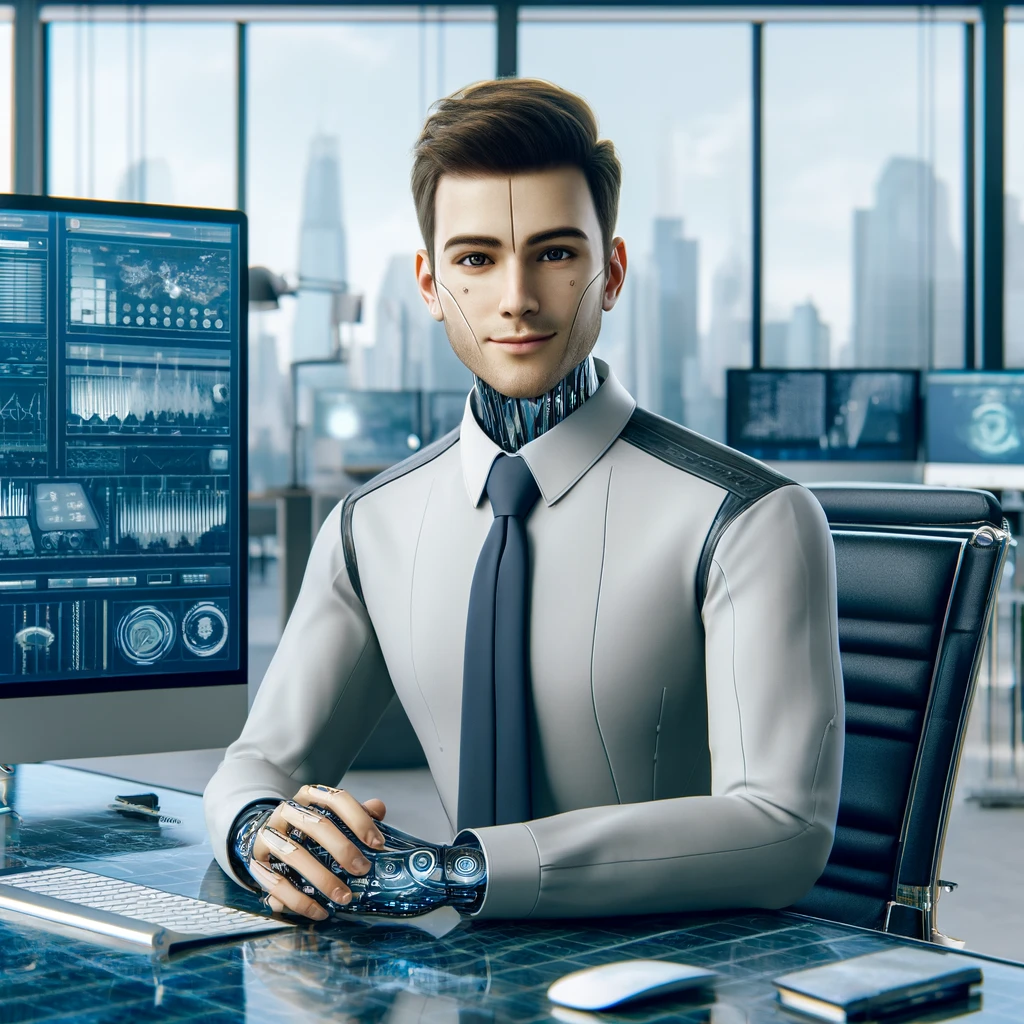

Prerequesite

# Install necessary libraries

In [1]:
!pip install pyautogen spider-env -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00


# 1. Configuration

In [7]:

import json
import os
from typing import Annotated, Dict
from spider_env import SpiderEnv
from autogen import ConversableAgent, UserProxyAgent, config_list_from_json
from google.colab import userdata

# 2. GenAI Model Configuration

In [8]:
os.environ["AUTOGEN_USE_DOCKER"] = "False"
llm_config = {
    "cache_seed": 48,
    "config_list": [{
        "model": "llama3-8b-8192",
        "api_key":userdata.get('GROQ_API_KEY'),
        "base_url": "https://api.groq.com/openai/v1"}
    ],
}

# How this Functional PoC works

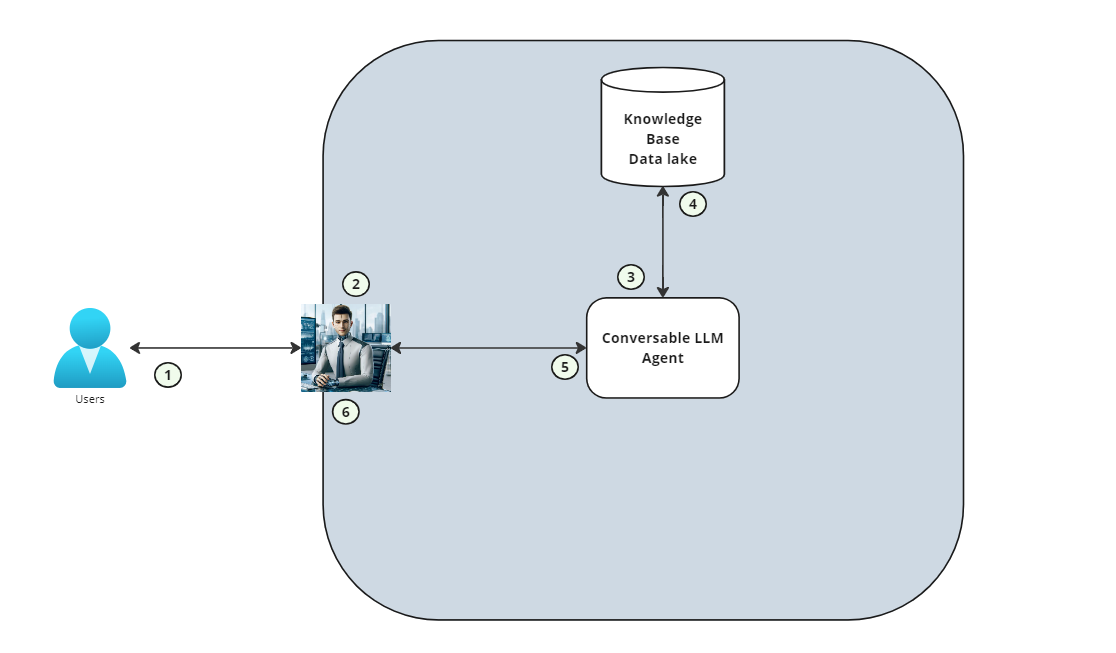

# 2. Import Data

In [4]:
gym = SpiderEnv()
observation, info = gym.reset()
question = observation["instruction"]
print(question)
schema = info["schema"]
print(schema)

Schema file not found for /root/.cache/spider/spider/database/company_1
Schema file not found for /root/.cache/spider/spider/database/small_bank_1
Schema file not found for /root/.cache/spider/spider/database/twitter_1
Schema file not found for /root/.cache/spider/spider/database/icfp_1
Schema file not found for /root/.cache/spider/spider/database/chinook_1
Schema file not found for /root/.cache/spider/spider/database/flight_4
Schema file not found for /root/.cache/spider/spider/database/epinions_1
Find the famous titles of artists that do not have any volume.
CREATE TABLE "artist" (
"Artist_ID" int,
"Artist" text,
"Age" int,
"Famous_Title" text,
"Famous_Release_date" text,
PRIMARY KEY ("Artist_ID")
);
CREATE TABLE "volume" (
"Volume_ID" int,
"Volume_Issue" text,
"Issue_Date" text,
"Weeks_on_Top" real,
"Song" text,
"Artist_ID" int,
PRIMARY KEY ("Volume_ID"),
FOREIGN KEY ("Artist_ID") REFERENCES "artist"("Artist_ID")
);
CREATE TABLE "music_festival" (
"ID" int,
"Music_Festival" text,
"D

# 3. Create Agents

In [30]:
def check_termination(msg: Dict):
    if "tool_responses" not in msg:
        return False
    json_str = msg["tool_responses"][0]["content"]
    obj = json.loads(json_str)
    return "error" not in obj or obj["error"] is None and obj["reward"] == 1

sql_writer = ConversableAgent(
    "sql_writer",
    llm_config=llm_config,
    system_message="You are good at writing SQL queries. Always respond with a function call to execute_sql().",
    is_termination_msg=check_termination)

user_proxy = UserProxyAgent(
    "user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10)

# 4. Create Tools / Function Calling

In [10]:
@sql_writer.register_for_llm(description="Function for executing SQL query and returning a response")
@user_proxy.register_for_execution()
def execute_sql(reflection: Annotated[str, "Think about what to do"], sql: Annotated[str, "SQL query"]) -> Annotated[Dict[str, str], "Dictionary with keys 'result' and 'error'"]:
    observation, reward, _, _, info = gym.step(sql)
    error = observation["feedback"]["error"]
    if not error and reward == 0:
        error = "The SQL query returned an incorrect result"
    if error:
        return { "error": error, "wrong_result": observation["feedback"]["result"], "correct_result": info["gold_result"], }
    else:
        return { "result": observation["feedback"]["result"], }

# 5. Initiate Chat

In [32]:
question

'Find the famous titles of artists that do not have any volume.'

In [31]:
# 5. Initiate Chat
prompt_template = f"""Below is the schema for a SQL database:
{schema}
Generate a SQL query to answer the following question:
{question}
"""
chat_result = user_proxy.initiate_chat(sql_writer, message=prompt_template)

user_proxy (to sql_writer):

Below is the schema for a SQL database:
CREATE TABLE "artist" (
"Artist_ID" int,
"Artist" text,
"Age" int,
"Famous_Title" text,
"Famous_Release_date" text,
PRIMARY KEY ("Artist_ID")
);
CREATE TABLE "volume" (
"Volume_ID" int,
"Volume_Issue" text,
"Issue_Date" text,
"Weeks_on_Top" real,
"Song" text,
"Artist_ID" int,
PRIMARY KEY ("Volume_ID"),
FOREIGN KEY ("Artist_ID") REFERENCES "artist"("Artist_ID")
);
CREATE TABLE "music_festival" (
"ID" int,
"Music_Festival" text,
"Date_of_ceremony" text,
"Category" text,
"Volume" int,
"Result" text,
PRIMARY KEY ("ID"),
FOREIGN KEY ("Volume") REFERENCES "volume"("Volume_ID")
);

Generate a SQL query to answer the following question:
Find the famous titles of artists that do not have any volume.


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
sql_writer (to user_proxy):

Here is the SQL query:

```
SELECT "Artist".Famous_Title
FROM "artist" LEFT JOIN "volume"

# Validate the output

In [41]:
gym = SpiderEnv()
observation, info = gym.reset()

# Extract the question (instruction) from the observation
question = observation["instruction"]
print("Instruction:", question)

# Extract the schema from the info
schema = info["schema"]
print("Schema:", schema)

# Define the SQL query
query = "SELECT A.Famous_Title FROM artist A WHERE A.Artist_ID NOT IN (SELECT V.Artist_ID FROM volume V)"

print("# Execute the query")

# Execute the query
gym.step(query)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading cached Spider dataset from /root/.cache/spider
Schema file not found for /root/.cache/spider/spider/database/company_1
Schema file not found for /root/.cache/spider/spider/database/small_bank_1
Schema file not found for /root/.cache/spider/spider/database/twitter_1
Schema file not found for /root/.cache/spider/spider/database/icfp_1
Schema file not found for /root/.cache/spider/spider/database/chinook_1
Schema file not found for /root/.cache/spider/spider/database/flight_4
Schema file not found for /root/.cache/spider/spider/database/epinions_1
Instruction: Find the famous titles of artists that do not have any volume.
Schema: CREATE TABLE "artist" (
"Artist_ID" int,
"Artist" text,
"Age" int,
"Famous_Title" text,
"Famous_Release_date" text,
PRIMARY KEY ("Artist_ID")
);
CREATE TABLE "volume" (
"Volume_ID" int,
"Volume_Issue" text,
"Issue_Date" text,
"Weeks_on_Top" real,
"Song" text,
"Artist_ID" int,
PRIMARY KEY ("Volume_ID"),
FOREIGN KEY ("Artist_ID") REFERENCES "artist"("Artist

({'observation': 'music_4',
  'instruction': 'Find the famous titles of artists that do not have any volume.',
  'feedback': {'result': [('Antievangelistical Process (re-release)',),
    ('Antithesis of All Flesh',)],
   'error': None}},
 1.0,
 False,
 False,
 {'schema': 'CREATE TABLE "artist" (\n"Artist_ID" int,\n"Artist" text,\n"Age" int,\n"Famous_Title" text,\n"Famous_Release_date" text,\nPRIMARY KEY ("Artist_ID")\n);\nCREATE TABLE "volume" (\n"Volume_ID" int,\n"Volume_Issue" text,\n"Issue_Date" text,\n"Weeks_on_Top" real,\n"Song" text,\n"Artist_ID" int,\nPRIMARY KEY ("Volume_ID"),\nFOREIGN KEY ("Artist_ID") REFERENCES "artist"("Artist_ID")\n);\nCREATE TABLE "music_festival" (\n"ID" int,\n"Music_Festival" text,\n"Date_of_ceremony" text,\n"Category" text,\n"Volume" int,\n"Result" text,\nPRIMARY KEY ("ID"),\nFOREIGN KEY ("Volume") REFERENCES "volume"("Volume_ID")\n);\n',
  'gold_query': 'SELECT Famous_Title FROM artist WHERE Artist_ID NOT IN(SELECT Artist_ID FROM volume)',
  'gold_res